<a href="https://colab.research.google.com/github/Quillbolt/colabnotebook/blob/main/ArcFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mxnet

     |████████████████████████████████| 55.0MB 70kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:

import cv2
import sys
import numpy as np
import mxnet as mx
import os
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from scipy import misc
import random
import sklearn
from sklearn.decomposition import PCA
from time import sleep
from easydict import EasyDict as edict
# from mtcnn_detector import MtcnnDetector
from skimage import transform as trans
import matplotlib.pyplot as plt
from mxnet.contrib.onnx.onnx2mx.import_model import import_model

In [ ]:

def get_model(ctx, model):
    image_size = (112,112)
    # Import ONNX model
    sym, arg_params, aux_params = import_model(model)
    # Define and binds parameters to the network
    model = mx.mod.Module(symbol=sym, context=ctx, label_names = None)
    model.bind(data_shapes=[('data', (1, 3, image_size[0], image_size[1]))])
    model.set_params(arg_params, aux_params)
    return model

In [ ]:
for i in range(4):
    mx.test_utils.download(dirname='mtcnn-model', url='https://s3.amazonaws.com/onnx-model-zoo/arcface/mtcnn-model/det{}-0001.params'.format(i+1))
    mx.test_utils.download(dirname='mtcnn-model', url='https://s3.amazonaws.com/onnx-model-zoo/arcface/mtcnn-model/det{}-symbol.json'.format(i+1))
    mx.test_utils.download(dirname='mtcnn-model', url='https://s3.amazonaws.com/onnx-model-zoo/arcface/mtcnn-model/det{}.caffemodel'.format(i+1))
    mx.test_utils.download(dirname='mtcnn-model', url='https://s3.amazonaws.com/onnx-model-zoo/arcface/mtcnn-model/det{}.prototxt'.format(i+1))

In [ ]:
def nms(boxes, overlap_threshold, mode='Union'):
    """
        non max suppression
    Parameters:
    ----------
        box: numpy array n x 5
            input bbox array
        overlap_threshold: float number
            threshold of overlap
        mode: float number
            how to compute overlap ratio, 'Union' or 'Min'
    Returns:
    -------
        index array of the selected bbox
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1, y1, x2, y2, score = [boxes[:, i] for i in range(5)]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(score)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        inter = w * h
        if mode == 'Min':
            overlap = inter / np.minimum(area[i], area[idxs[:last]])
        else:
            overlap = inter / (area[i] + area[idxs[:last]] - inter)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlap_threshold)[0])))

    return pick

def adjust_input(in_data):
    """
        adjust the input from (h, w, c) to ( 1, c, h, w) for network input
    Parameters:
    ----------
        in_data: numpy array of shape (h, w, c)
            input data
    Returns:
    -------
        out_data: numpy array of shape (1, c, h, w)
            reshaped array
    """
    if in_data.dtype is not np.dtype('float32'):
        out_data = in_data.astype(np.float32)
    else:
        out_data = in_data

    out_data = out_data.transpose((2,0,1))
    out_data = np.expand_dims(out_data, 0)
    out_data = (out_data - 127.5)*0.0078125
    return out_data

def generate_bbox(map, reg, scale, threshold):
     """
         generate bbox from feature map
     Parameters:
     ----------
         map: numpy array , n x m x 1
             detect score for each position
         reg: numpy array , n x m x 4
             bbox
         scale: float number
             scale of this detection
         threshold: float number
             detect threshold
     Returns:
     -------
         bbox array
     """
     stride = 2
     cellsize = 12

     t_index = np.where(map>threshold)

     # find nothing
     if t_index[0].size == 0:
         return np.array([])

     dx1, dy1, dx2, dy2 = [reg[0, i, t_index[0], t_index[1]] for i in range(4)]

     reg = np.array([dx1, dy1, dx2, dy2])
     score = map[t_index[0], t_index[1]]
     boundingbox = np.vstack([np.round((stride*t_index[1]+1)/scale),
                              np.round((stride*t_index[0]+1)/scale),
                              np.round((stride*t_index[1]+1+cellsize)/scale),
                              np.round((stride*t_index[0]+1+cellsize)/scale),
                              score,
                              reg])

     return boundingbox.T


def detect_first_stage(img, net, scale, threshold):
    """
        run PNet for first stage
    
    Parameters:
    ----------
        img: numpy array, bgr order
            input image
        scale: float number
            how much should the input image scale
        net: PNet
            worker
    Returns:
    -------
        total_boxes : bboxes
    """
    height, width, _ = img.shape
    hs = int(math.ceil(height * scale))
    ws = int(math.ceil(width * scale))
    
    im_data = cv2.resize(img, (ws,hs))
    
    # adjust for the network input
    input_buf = adjust_input(im_data)
    output = net.predict(input_buf)
    boxes = generate_bbox(output[1][0,1,:,:], output[0], scale, threshold)

    if boxes.size == 0:
        return None

    # nms
    pick = nms(boxes[:,0:5], 0.5, mode='Union')
    boxes = boxes[pick]
    return boxes

def detect_first_stage_warpper( args ):
    return detect_first_stage(*args)

In [ ]:
import os
import mxnet as mx
import numpy as np
import math
import cv2
from multiprocessing import Pool
from itertools import repeat
# from itertools import zip
# from helper import nms, adjust_input, generate_bbox, detect_first_stage_warpper

class MtcnnDetector(object):
    """
        Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Neural Networks
        see https://github.com/kpzhang93/MTCNN_face_detection_alignment
        this is a mxnet version
    """
    def __init__(self,
                 model_folder='.',
                 minsize = 20,
                 threshold = [0.6, 0.7, 0.8],
                 factor = 0.709,
                 num_worker = 1,
                 accurate_landmark = False,
                 ctx=mx.cpu()):
        """
            Initialize the detector
            Parameters:
            ----------
                model_folder : string
                    path for the models
                minsize : float number
                    minimal face to detect
                threshold : float number
                    detect threshold for 3 stages
                factor: float number
                    scale factor for image pyramid
                num_worker: int number
                    number of processes we use for first stage
                accurate_landmark: bool
                    use accurate landmark localization or not
        """
        self.num_worker = num_worker
        self.accurate_landmark = accurate_landmark

        # load 4 models from folder
        models = ['det1', 'det2', 'det3','det4']
        models = [ os.path.join(model_folder, f) for f in models]
        
        self.PNets = []
        for i in range(num_worker):
            workner_net = mx.model.FeedForward.load(models[0], 1, ctx=ctx)
            self.PNets.append(workner_net)

        self.Pool = Pool(num_worker)

        self.RNet = mx.model.FeedForward.load(models[1], 1, ctx=ctx)
        self.ONet = mx.model.FeedForward.load(models[2], 1, ctx=ctx)
        self.LNet = mx.model.FeedForward.load(models[3], 1, ctx=ctx)

        self.minsize   = float(minsize)
        self.factor    = float(factor)
        self.threshold = threshold


    def convert_to_square(self, bbox):
        """
            convert bbox to square
        Parameters:
        ----------
            bbox: numpy array , shape n x 5
                input bbox
        Returns:
        -------
            square bbox
        """
        square_bbox = bbox.copy()

        h = bbox[:, 3] - bbox[:, 1] + 1
        w = bbox[:, 2] - bbox[:, 0] + 1
        max_side = np.maximum(h,w)
        square_bbox[:, 0] = bbox[:, 0] + w*0.5 - max_side*0.5
        square_bbox[:, 1] = bbox[:, 1] + h*0.5 - max_side*0.5
        square_bbox[:, 2] = square_bbox[:, 0] + max_side - 1
        square_bbox[:, 3] = square_bbox[:, 1] + max_side - 1
        return square_bbox

    def calibrate_box(self, bbox, reg):
        """
            calibrate bboxes
        Parameters:
        ----------
            bbox: numpy array, shape n x 5
                input bboxes
            reg:  numpy array, shape n x 4
                bboxex adjustment
        Returns:
        -------
            bboxes after refinement
        """
        w = bbox[:, 2] - bbox[:, 0] + 1
        w = np.expand_dims(w, 1)
        h = bbox[:, 3] - bbox[:, 1] + 1
        h = np.expand_dims(h, 1)
        reg_m = np.hstack([w, h, w, h])
        aug = reg_m * reg
        bbox[:, 0:4] = bbox[:, 0:4] + aug
        return bbox

 
    def pad(self, bboxes, w, h):
        """
            pad the the bboxes, alse restrict the size of it
        Parameters:
        ----------
            bboxes: numpy array, n x 5
                input bboxes
            w: float number
                width of the input image
            h: float number
                height of the input image
        Returns :
        ------s
            dy, dx : numpy array, n x 1
                start point of the bbox in target image
            edy, edx : numpy array, n x 1
                end point of the bbox in target image
            y, x : numpy array, n x 1
                start point of the bbox in original image
            ex, ex : numpy array, n x 1
                end point of the bbox in original image
            tmph, tmpw: numpy array, n x 1
                height and width of the bbox
        """
        tmpw, tmph = bboxes[:, 2] - bboxes[:, 0] + 1,  bboxes[:, 3] - bboxes[:, 1] + 1
        num_box = bboxes.shape[0]

        dx , dy= np.zeros((num_box, )), np.zeros((num_box, ))
        edx, edy  = tmpw.copy()-1, tmph.copy()-1

        x, y, ex, ey = bboxes[:, 0], bboxes[:, 1], bboxes[:, 2], bboxes[:, 3]

        tmp_index = np.where(ex > w-1)
        edx[tmp_index] = tmpw[tmp_index] + w - 2 - ex[tmp_index]
        ex[tmp_index] = w - 1

        tmp_index = np.where(ey > h-1)
        edy[tmp_index] = tmph[tmp_index] + h - 2 - ey[tmp_index]
        ey[tmp_index] = h - 1

        tmp_index = np.where(x < 0)
        dx[tmp_index] = 0 - x[tmp_index]
        x[tmp_index] = 0

        tmp_index = np.where(y < 0)
        dy[tmp_index] = 0 - y[tmp_index]
        y[tmp_index] = 0

        return_list = [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph]
        return_list = [item.astype(np.int32) for item in return_list]

        return  return_list

    def slice_index(self, number):
        """
            slice the index into (n,n,m), m < n
        Parameters:
        ----------
            number: int number
                number
        """
        def chunks(l, n):
            """Yield successive n-sized chunks from l."""
            for i in range(0, len(l), n):
                yield l[i:i + n]
        num_list = range(number)
        return list(chunks(num_list, self.num_worker))
        

    def detect_face(self, img):
        """
            detect face over img
        Parameters:
        ----------
            img: numpy array, bgr order of shape (1, 3, n, m)
                input image
        Retures:
        -------
            bboxes: numpy array, n x 5 (x1,y2,x2,y2,score)
                bboxes
            points: numpy array, n x 10 (x1, x2 ... x5, y1, y2 ..y5)
                landmarks
        """

        # check input
        MIN_DET_SIZE = 12

        if img is None:
            return None

        # only works for color image
        if len(img.shape) != 3:
            return None

        # detected boxes
        total_boxes = []

        height, width, _ = img.shape
        minl = min( height, width)

        # get all the valid scales
        scales = []
        m = MIN_DET_SIZE/self.minsize
        minl *= m
        factor_count = 0
        while minl > MIN_DET_SIZE:
            scales.append(m*self.factor**factor_count)
            minl *= self.factor
            factor_count += 1

        #############################################
        # first stage
        #############################################
        #for scale in scales:
        #    return_boxes = self.detect_first_stage(img, scale, 0)
        #    if return_boxes is not None:
        #        total_boxes.append(return_boxes)
        
        sliced_index = self.slice_index(len(scales))
        total_boxes = []
        for batch in sliced_index:
            local_boxes = self.Pool.map( detect_first_stage_warpper, \
                    zip(repeat(img), self.PNets[:len(batch)], [scales[i] for i in batch], repeat(self.threshold[0])) )
            total_boxes.extend(local_boxes)
        
        # remove the Nones 
        total_boxes = [ i for i in total_boxes if i is not None]

        if len(total_boxes) == 0:
            return None
        
        total_boxes = np.vstack(total_boxes)

        if total_boxes.size == 0:
            return None

        # merge the detection from first stage
        pick = nms(total_boxes[:, 0:5], 0.7, 'Union')
        total_boxes = total_boxes[pick]

        bbw = total_boxes[:, 2] - total_boxes[:, 0] + 1
        bbh = total_boxes[:, 3] - total_boxes[:, 1] + 1

        # refine the bboxes
        total_boxes = np.vstack([total_boxes[:, 0]+total_boxes[:, 5] * bbw,
                                 total_boxes[:, 1]+total_boxes[:, 6] * bbh,
                                 total_boxes[:, 2]+total_boxes[:, 7] * bbw,
                                 total_boxes[:, 3]+total_boxes[:, 8] * bbh,
                                 total_boxes[:, 4]
                                 ])

        total_boxes = total_boxes.T
        total_boxes = self.convert_to_square(total_boxes)
        total_boxes[:, 0:4] = np.round(total_boxes[:, 0:4])

        #############################################
        # second stage
        #############################################
        num_box = total_boxes.shape[0]

        # pad the bbox
        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(total_boxes, width, height)
        # (3, 24, 24) is the input shape for RNet
        input_buf = np.zeros((num_box, 3, 24, 24), dtype=np.float32)

        for i in range(num_box):
            tmp = np.zeros((tmph[i], tmpw[i], 3), dtype=np.uint8)
            tmp[dy[i]:edy[i]+1, dx[i]:edx[i]+1, :] = img[y[i]:ey[i]+1, x[i]:ex[i]+1, :]
            input_buf[i, :, :, :] = adjust_input(cv2.resize(tmp, (24, 24)))

        output = self.RNet.predict(input_buf)

        # filter the total_boxes with threshold
        passed = np.where(output[1][:, 1] > self.threshold[1])
        total_boxes = total_boxes[passed]

        if total_boxes.size == 0:
            return None

        total_boxes[:, 4] = output[1][passed, 1].reshape((-1,))
        reg = output[0][passed]

        # nms
        pick = nms(total_boxes, 0.7, 'Union')
        total_boxes = total_boxes[pick]
        total_boxes = self.calibrate_box(total_boxes, reg[pick])
        total_boxes = self.convert_to_square(total_boxes)
        total_boxes[:, 0:4] = np.round(total_boxes[:, 0:4])

        #############################################
        # third stage
        #############################################
        num_box = total_boxes.shape[0]

        # pad the bbox
        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(total_boxes, width, height)
        # (3, 48, 48) is the input shape for ONet
        input_buf = np.zeros((num_box, 3, 48, 48), dtype=np.float32)

        for i in range(num_box):
            tmp = np.zeros((tmph[i], tmpw[i], 3), dtype=np.float32)
            tmp[dy[i]:edy[i]+1, dx[i]:edx[i]+1, :] = img[y[i]:ey[i]+1, x[i]:ex[i]+1, :]
            input_buf[i, :, :, :] = adjust_input(cv2.resize(tmp, (48, 48)))

        output = self.ONet.predict(input_buf)

        # filter the total_boxes with threshold
        passed = np.where(output[2][:, 1] > self.threshold[2])
        total_boxes = total_boxes[passed]

        if total_boxes.size == 0:
            return None

        total_boxes[:, 4] = output[2][passed, 1].reshape((-1,))
        reg = output[1][passed]
        points = output[0][passed]

        # compute landmark points
        bbw = total_boxes[:, 2] - total_boxes[:, 0] + 1
        bbh = total_boxes[:, 3] - total_boxes[:, 1] + 1
        points[:, 0:5] = np.expand_dims(total_boxes[:, 0], 1) + np.expand_dims(bbw, 1) * points[:, 0:5]
        points[:, 5:10] = np.expand_dims(total_boxes[:, 1], 1) + np.expand_dims(bbh, 1) * points[:, 5:10]

        # nms
        total_boxes = self.calibrate_box(total_boxes, reg)
        pick = nms(total_boxes, 0.7, 'Min')
        total_boxes = total_boxes[pick]
        points = points[pick]
        
        if not self.accurate_landmark:
            return total_boxes, points

        #############################################
        # extended stage
        #############################################
        num_box = total_boxes.shape[0]
        patchw = np.maximum(total_boxes[:, 2]-total_boxes[:, 0]+1, total_boxes[:, 3]-total_boxes[:, 1]+1)
        patchw = np.round(patchw*0.25)

        # make it even
        patchw[np.where(np.mod(patchw,2) == 1)] += 1

        input_buf = np.zeros((num_box, 15, 24, 24), dtype=np.float32)
        for i in range(5):
            x, y = points[:, i], points[:, i+5]
            x, y = np.round(x-0.5*patchw), np.round(y-0.5*patchw)
            [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(np.vstack([x, y, x+patchw-1, y+patchw-1]).T,
                                                                    width,
                                                                    height)
            for j in range(num_box):
                tmpim = np.zeros((tmpw[j], tmpw[j], 3), dtype=np.float32)
                tmpim[dy[j]:edy[j]+1, dx[j]:edx[j]+1, :] = img[y[j]:ey[j]+1, x[j]:ex[j]+1, :]
                input_buf[j, i*3:i*3+3, :, :] = adjust_input(cv2.resize(tmpim, (24, 24)))

        output = self.LNet.predict(input_buf)

        pointx = np.zeros((num_box, 5))
        pointy = np.zeros((num_box, 5))

        for k in range(5):
            # do not make a large movement
            tmp_index = np.where(np.abs(output[k]-0.5) > 0.35)
            output[k][tmp_index[0]] = 0.5

            pointx[:, k] = np.round(points[:, k] - 0.5*patchw) + output[k][:, 0]*patchw
            pointy[:, k] = np.round(points[:, k+5] - 0.5*patchw) + output[k][:, 1]*patchw

        points = np.hstack([pointx, pointy])
        points = points.astype(np.int32)

        return total_boxes, points

    def list2colmatrix(self, pts_list):
        """
            convert list to column matrix
        Parameters:
        ----------
            pts_list:
                input list
        Retures:
        -------
            colMat: 
        """
        assert len(pts_list) > 0
        colMat = []
        for i in range(len(pts_list)):
            colMat.append(pts_list[i][0])
            colMat.append(pts_list[i][1])
        colMat = np.matrix(colMat).transpose()
        return colMat

    def find_tfrom_between_shapes(self, from_shape, to_shape):
        """
            find transform between shapes
        Parameters:
        ----------
            from_shape: 
            to_shape: 
        Retures:
        -------
            tran_m:
            tran_b:
        """
        assert from_shape.shape[0] == to_shape.shape[0] and from_shape.shape[0] % 2 == 0

        sigma_from = 0.0
        sigma_to = 0.0
        cov = np.matrix([[0.0, 0.0], [0.0, 0.0]])

        # compute the mean and cov
        from_shape_points = from_shape.reshape(from_shape.shape[0]/2, 2)
        to_shape_points = to_shape.reshape(to_shape.shape[0]/2, 2)
        mean_from = from_shape_points.mean(axis=0)
        mean_to = to_shape_points.mean(axis=0)

        for i in range(from_shape_points.shape[0]):
            temp_dis = np.linalg.norm(from_shape_points[i] - mean_from)
            sigma_from += temp_dis * temp_dis
            temp_dis = np.linalg.norm(to_shape_points[i] - mean_to)
            sigma_to += temp_dis * temp_dis
            cov += (to_shape_points[i].transpose() - mean_to.transpose()) * (from_shape_points[i] - mean_from)

        sigma_from = sigma_from / to_shape_points.shape[0]
        sigma_to = sigma_to / to_shape_points.shape[0]
        cov = cov / to_shape_points.shape[0]

        # compute the affine matrix
        s = np.matrix([[1.0, 0.0], [0.0, 1.0]])
        u, d, vt = np.linalg.svd(cov)

        if np.linalg.det(cov) < 0:
            if d[1] < d[0]:
                s[1, 1] = -1
            else:
                s[0, 0] = -1
        r = u * s * vt
        c = 1.0
        if sigma_from != 0:
            c = 1.0 / sigma_from * np.trace(np.diag(d) * s)

        tran_b = mean_to.transpose() - c * r * mean_from.transpose()
        tran_m = c * r

        return tran_m, tran_b

    def extract_image_chips(self, img, points, desired_size=256, padding=0):
        """
            crop and align face
        Parameters:
        ----------
            img: numpy array, bgr order of shape (1, 3, n, m)
                input image
            points: numpy array, n x 10 (x1, x2 ... x5, y1, y2 ..y5)
            desired_size: default 256
            padding: default 0
        Retures:
        -------
            crop_imgs: list, n
                cropped and aligned faces 
        """
        crop_imgs = []
        for p in points:
            shape  =[]
            for k in range(len(p)/2):
                shape.append(p[k])
                shape.append(p[k+5])

            if padding > 0:
                padding = padding
            else:
                padding = 0
            # average positions of face points
            mean_face_shape_x = [0.224152, 0.75610125, 0.490127, 0.254149, 0.726104]
            mean_face_shape_y = [0.2119465, 0.2119465, 0.628106, 0.780233, 0.780233]

            from_points = []
            to_points = []

            for i in range(len(shape)/2):
                x = (padding + mean_face_shape_x[i]) / (2 * padding + 1) * desired_size
                y = (padding + mean_face_shape_y[i]) / (2 * padding + 1) * desired_size
                to_points.append([x, y])
                from_points.append([shape[2*i], shape[2*i+1]])

            # convert the points to Mat
            from_mat = self.list2colmatrix(from_points)
            to_mat = self.list2colmatrix(to_points)

            # compute the similar transfrom
            tran_m, tran_b = self.find_tfrom_between_shapes(from_mat, to_mat)

            probe_vec = np.matrix([1.0, 0.0]).transpose()
            probe_vec = tran_m * probe_vec

            scale = np.linalg.norm(probe_vec)
            angle = 180.0 / math.pi * math.atan2(probe_vec[1, 0], probe_vec[0, 0])

            from_center = [(shape[0]+shape[2])/2.0, (shape[1]+shape[3])/2.0]
            to_center = [0, 0]
            to_center[1] = desired_size * 0.4
            to_center[0] = desired_size * 0.5

            ex = to_center[0] - from_center[0]
            ey = to_center[1] - from_center[1]

            rot_mat = cv2.getRotationMatrix2D((from_center[0], from_center[1]), -1*angle, scale)
            rot_mat[0][2] += ex
            rot_mat[1][2] += ey

            chips = cv2.warpAffine(img, rot_mat, (desired_size, desired_size))
            crop_imgs.append(chips)

        return crop_imgs


In [ ]:

# Determine and set context
if len(mx.test_utils.list_gpus())==0:
    ctx = mx.cpu()
else:
    ctx = mx.gpu(0)
# Configure face detector
det_threshold = [0.6,0.7,0.8]
mtcnn_path = os.path.join(os.path.dirname('__file__'), 'mtcnn-model')
detector = MtcnnDetector(model_folder=mtcnn_path, ctx=ctx, num_worker=1, accurate_landmark = True, threshold=det_threshold)

In [ ]:
def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = []
    str_image_size = kwargs.get('image_size', '')
    # Assert input shape
    if len(str_image_size)>0:
        image_size = [int(x) for x in str_image_size.split(',')]
        if len(image_size)==1:
            image_size = [image_size[0], image_size[0]]
        assert len(image_size)==2
        assert image_size[0]==112
        assert image_size[0]==112 or image_size[1]==96
    
    # Do alignment using landmark points
    if landmark is not None:
        assert len(image_size)==2
        src = np.array([
          [30.2946, 51.6963],
          [65.5318, 51.5014],
          [48.0252, 71.7366],
          [33.5493, 92.3655],
          [62.7299, 92.2041] ], dtype=np.float32 )
        if image_size[1]==112:
            src[:,0] += 8.0
        dst = landmark.astype(np.float32)
        tform = trans.SimilarityTransform()
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped
    
    # If no landmark points available, do alignment using bounding box. If no bounding box available use center crop
    if M is None:
        if bbox is None:
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
            det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin/2, 0)
        bb[1] = np.maximum(det[1]-margin/2, 0)
        bb[2] = np.minimum(det[2]+margin/2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin/2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
            ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret
    
def get_input(detector,face_img):
    # Pass input images through face detector
    ret = detector.detect_face(face_img)
    if ret is None:
        return None
    bbox, points = ret
    if bbox.shape[0]==0:
        return None
    bbox = bbox[0,0:4]
    points = points[0,:].reshape((2,5)).T
    # Call preprocess() to generate aligned images
    nimg = preprocess(face_img, bbox, points, image_size='112,112')
    nimg = cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB)
    aligned = np.transpose(nimg, (2,0,1))
    return aligned

In [ ]:
def get_feature(model,aligned):
    input_blob = np.expand_dims(aligned, axis=0)
    data = mx.nd.array(input_blob)
    db = mx.io.DataBatch(data=(data,))
    model.forward(db, is_train=False)
    embedding = model.get_outputs()[0].asnumpy()
    embedding = sklearn.preprocessing.normalize(embedding).flatten()
    return embedding

In [ ]:
# Download first image
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/arcface/player1.jpg')
# Download second image
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/arcface/player2.jpg')
# Download onnx model
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/arcface/resnet100.onnx')

'resnet100.onnx'

In [ ]:
model_name = '/content/resnet100.onnx'

In [ ]:
!pip install onnx

     |████████████████████████████████| 7.7MB 3.2MB/s 


In [ ]:
model = get_model(ctx , model_name)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import sklearn
from scipy import interpolate
from scipy.spatial.distance import pdist


# Support: ['calculate_roc', 'calculate_accuracy', 'calculate_val', 'calculate_val_far', 'evaluate']


def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds = 10, pca = 0):
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits = nrof_folds, shuffle = False)

    tprs = np.zeros((nrof_folds, nrof_thresholds))
    fprs = np.zeros((nrof_folds, nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    best_thresholds = np.zeros((nrof_folds))
    indices = np.arange(nrof_pairs)
    # print('pca', pca)

    if pca == 0:
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff), 1)
        # dist = pdist(np.vstack([embeddings1, embeddings2]), 'cosine')

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # print('train_set', train_set)
        # print('test_set', test_set)
        if pca > 0:
            print("doing pca on", fold_idx)
            embed1_train = embeddings1[train_set]
            embed2_train = embeddings2[train_set]
            _embed_train = np.concatenate((embed1_train, embed2_train), axis = 0)
            # print(_embed_train.shape)
            pca_model = PCA(n_components = pca)
            pca_model.fit(_embed_train)
            embed1 = pca_model.transform(embeddings1)
            embed2 = pca_model.transform(embeddings2)
            embed1 = sklearn.preprocessing.normalize(embed1)
            embed2 = sklearn.preprocessing.normalize(embed2)
            # print(embed1.shape, embed2.shape)
            diff = np.subtract(embed1, embed2)
            dist = np.sum(np.square(diff), 1)

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
#         print('best_threshold_index', best_threshold_index, acc_train[best_threshold_index])
        best_thresholds[fold_idx] = thresholds[best_threshold_index]
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = calculate_accuracy(threshold,
                                                                                                 dist[test_set],
                                                                                                 actual_issame[
                                                                                                     test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

    tpr = np.mean(tprs, 0)
    fpr = np.mean(fprs, 0)
    return tpr, fpr, accuracy, best_thresholds


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / dist.size
    return tpr, fpr, acc


def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds = 10):
    '''
    Copy from [insightface](https://github.com/deepinsight/insightface)
    :param thresholds:
    :param embeddings1:
    :param embeddings2:
    :param actual_issame:
    :param far_target:
    :param nrof_folds:
    :return:
    '''
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits = nrof_folds, shuffle = False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff), 1)
    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train) >= far_target:
            f = interpolate.interp1d(far_train, thresholds, kind = 'slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far


def evaluate(embeddings, actual_issame, nrof_folds = 10, pca = 0):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy, best_thresholds = calculate_roc(thresholds, embeddings1, embeddings2, np.asarray(actual_issame), nrof_folds = nrof_folds, pca = pca)
#     thresholds = np.arange(0, 4, 0.001)
#     val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
#                                       np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds)
#     return tpr, fpr, accuracy, best_thresholds, val, val_std, far
    return tpr, fpr, accuracy, best_thresholds


In [ ]:
img1 = cv2.imread('/content/drive/My Drive/data/traindata/id0/id0_01.jpg')
img2 = cv2.imread('/content/drive/My Drive/data/traindata/id0/id0_08.jpg')

In [ ]:
pre1 = get_input(detector,img1)
pre2 = get_input(detector,img2)

In [ ]:
embed1 = get_feature(model,pre1)
embed2 = get_feature(model,pre2)

In [ ]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric 
        
    return dist

In [ ]:
distance(embed1.reshape(1,-1),embed2.reshape(1,-1),distance_metric=0)

array([0.62789106], dtype=float32)

In [ ]:
np.sum(np.square(embed1-embed2))

0.62789106

In [ ]:
np.dot(embed1, embed2.T)

0.68605447

In [ ]:
thresholds = np.arange(0, 4, 0.001)

In [ ]:
calculate_val(thresholds,embed1,embed2)

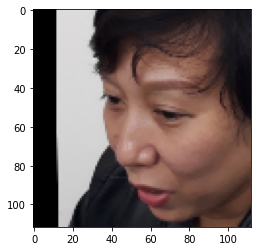

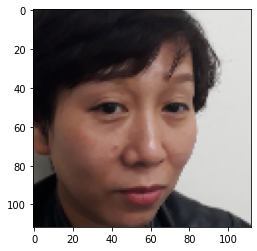

In [ ]:
  plt.imshow(np.transpose(pre1,(1,2,0)))
  plt.show()
  plt.imshow(np.transpose(pre2,(1,2,0)))
  plt.show()

In [ ]:
import PIL
import numpy as np
import torch
import torchvision
from PIL import ImageFile



In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

In [ ]:
dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/godeyedata', transform=transforms)

In [ ]:
import os
os.chdir('/content/drive/My Drive/insightface/deploy')

In [ ]:
from face_embedding import FaceModel

In [ ]:
from dataclasses import dataclass

# =================== Data Class For Left Panel ====================
@dataclass
class ImageName():
    "Stores the paths to images for a given class"
    name: str
    image_paths: str

    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'

    def __len__(self):
        return len(self.image_paths)

In [ ]:
def do_flip(data):
    for idx in range(data.shape[0]):
        data[idx, :, :] = np.fliplr(data[idx, :, :])


In [ ]:
def get_image_paths(facedir):
    image_paths = []
    if os.path.isdir(facedir):
        images = os.listdir(facedir)
        image_paths = [os.path.join(facedir, img) for img in images]
    return image_paths

In [ ]:
get_image_paths('/content/drive/My Drive/face.evoLVe.PyTorch/train')

['/content/drive/My Drive/face.evoLVe.PyTorch/train/Nguyễn Duy Khánh-MT-013',
 '/content/drive/My Drive/face.evoLVe.PyTorch/train/Nguyễn Đức Điệp-MT-004',
 '/content/drive/My Drive/face.evoLVe.PyTorch/train/Huỳnh Tuấn Minh - MT-014',
 '/content/drive/My Drive/face.evoLVe.PyTorch/train/Trần Tiến Hòa-MT-002',
 '/content/drive/My Drive/face.evoLVe.PyTorch/train/MT - 009 Đỗ Văn Trường - done']

In [ ]:

def get_dataset(path, has_class_directories=True):
    dataset = []
    path_exp = os.path.expanduser(path)
    classes = [
        path for path in os.listdir(path_exp)
        if os.path.isdir(os.path.join(path_exp, path))
    ]
    classes.sort()
    nrof_classes = len(classes)
    for i in range(nrof_classes):
        class_name = classes[i]
        facedir = os.path.join(path_exp, class_name)
        image_paths = get_image_paths(facedir)
        dataset.append(ImageName(class_name, image_paths))

    return dataset

In [ ]:
a=get_dataset('/content/drive/My Drive/face.evoLVe.PyTorch/train')

In [ ]:
def get_image_paths_and_labels(dataset):
    image_paths_flat = []
    labels_flat = []
    for item in dataset:
        image_paths_flat += item.image_paths
        labels_flat += [item.name] * len(item.image_paths)
        # labels_flat.append(item.name)
    return image_paths_flat, labels_flat

In [ ]:
get_image_paths_and_labels(a)

In [ ]:
img_paths = '/content/drive/My Drive/face.evoLVe.PyTorch/train/Huỳnh Tuấn Minh - MT-014'

In [ ]:
for counter,path in enumerate(get_image_paths(img_paths)):
            print(img_paths)
            print(counter)
            nimg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            aligned = np.transpose(nimg, (2, 0, 1))

In [ ]:
def get_features_from_path(img_paths,model=model):
    result = []
    for counter, path in enumerate(img_paths):
        # print(type(len(img_paths)))
        # print(type(counter))
        nimg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        aligned = np.transpose(nimg, (2, 0, 1))
        embedding = None
        for flipid in [0, 1]:
            if flipid == 1:
                do_flip(aligned)

            input_blob = np.expand_dims(aligned, axis=0)
            data = mx.nd.array(input_blob)
            db = mx.io.DataBatch(data=(data, ))
            model.forward(db, is_train=False)
            _embedding = model.get_outputs()[0].asnumpy()
            # print(_embedding.shape)
            if embedding is None:
                embedding = _embedding
            else:
                embedding += _embedding
        embedding = sklearn.preprocessing.normalize(embedding).flatten()
        result.append(embedding)
        # print()
        print('percent%2f%%' % ((counter + 1) * 100 / len(img_paths)))
    return result

In [ ]:
get_features_from_path('/content/drive/My Drive/face.evoLVe.PyTorch/train/Huỳnh Tuấn Minh - MT-014')

In [ ]:
detector = MtcnnDetector(model_folder=mtcnn_path, ctx=ctx, num_worker=1, accurate_landmark = True, threshold=det_threshold)
arcface = FaceModel.get_feature

In [ ]:
import os
os.chdir('/content/drive/My Drive')

In [ ]:
dir_train = './content/drive/My Drive/face.npy'
data_train = '/content/drive/My Drive/face.evoLVe.PyTorch/train'
dataset_train = get_dataset(data_train)
paths_train, labels_train = get_image_paths_and_labels(dataset_train)

In [ ]:
#detector.get_all_boxes_from_path(paths_train, save_img=True)
dataset_train = get_dataset(data_train)
paths_train, labels_train = get_image_paths_and_labels(dataset_train)
train_emb_array = get_features_from_path(paths_train)
#np.save(dir_train, train_emb_array)

In [ ]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [ ]:
pre1=get_input(detector,cv2.imread('/content/drive/My Drive/face.evoLVe.PyTorch/train/Trần Tiến Hòa-MT-002/MT-002-12.png'))

In [ ]:
pre2=get_input(detector,cv2.imread('/content/player2.jpg'))

In [ ]:

def calc_dist(pre1, pre2):
    out1 = get_feature(model, pre1)
    out2 = get_feature(model, pre2)
    return np.sum(np.square(out1-out2))

In [ ]:
def calc_dist_plot(pre1, pre2):
    print(calc_dist(pre1, pre2))
    plt.imshow(np.transpose(pre1,(1,2,0)))
    plt.show()
    plt.imshow(np.transpose(pre2,(1,2,0)))
    plt.show()

4035766


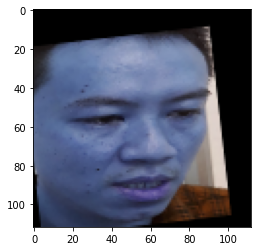

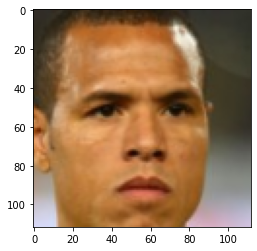

In [ ]:
calc_dist_plot(pre1,pre2)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [ ]:
print('Train dataset reloaded: ', len(train_emb_array))

class_names = [cls.name.replace('_', ' ') for cls in dataset_train]
print(class_names)

mlp = MLPClassifier(hidden_layer_sizes=(550, ), verbose=True,
                    activation='relu', solver='adam', tol=10e-7, n_iter_no_change=100,
                    learning_rate_init=1e-3, max_iter=50000)

mlp.fit(train_emb_array, labels_train)


In [ ]:
import joblib

In [ ]:

model_path ="/content/drive/My Drive/WANDB/"
joblib.dump((mlp,class_names), model_path+"mlp.pkl")

In [ ]:
def read_pkl_model(mpath):
    with open(mpath, 'rb') as infile:
        (mlp, class_names) = joblib.load(infile)
        print('FR model loadded: ', class_names)
        return mlp, class_names

In [ ]:
mlp,class_names = read_pkl_model('/content/drive/My Drive/WANDB/mlp.pkl')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
file ='/content/Angel-Di-Maria-Real-Madrid-vs-Bayern-Munich_2797421.jpg'

In [ ]:
xtest = cv2.imread(file)

In [ ]:
pre1=get_input(detector,xtest)

In [ ]:
print(pre1)

In [ ]:
out1=get_feature(model,pre1)

In [ ]:
mlp.predict_proba(out1.reshape(1,-1))

In [ ]:
plt.imshow(np.transpose(pre1,(1,2,0)))
plt.show()

In [ ]:
mlp.predict(out1.reshape(1,-1))

In [ ]:
out=get_feature(model,get_input(detector,cv2.imread('/content/drive/My Drive/face.evoLVe.PyTorch/train/Trần Tiến Hòa-MT-002/MT-002-12.png')))

In [ ]:
import torch.nn as nn
import torch

In [ ]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
print(output.backward())

In [ ]:
#y_pred = mlp.predict()

x = mlp.score(out1.reshape(1,-1), out.reshape(1,-1))


In [ ]:

# Load first image
img1 = cv2.imread('player1.jpg')
# Display first image
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
pre1 = get_input(detector,img1)
# Display preprocessed image
plt.imshow(np.transpose(pre1,(1,2,0)))
plt.show()
# Get embedding of first image
out1 = get_feature(model,pre1)
print(out1)

In [ ]:
img = '/content/drive/My Drive/face.evoLVe.PyTorch/train/Huỳnh Tuấn Minh - MT-014/MT-014-1.png'
image = cv2.imread(img)
y = get_input(detector,image)

x = get_feature(model,y)
print(x)

In [ ]:
# Compute squared distance between embeddings
dist = np.sum(np.square(out1-out3))
# Compute cosine similarity between embedddings
sim = np.dot(out1, out3.T)
# Print predictions
print('Distance = %f' %(dist))
print('Similarity = %f' %(sim))

In [ ]:

print(np.__version__)
print(mx.__version__)
print(sklearn.__version__)
#print(easydict.__version__)
print(skimage.__version__)
print(onnx.__version__)
print(matplotlib.__version__)
print(cv2.__version__)

In [ ]:
import argparse
from collections import defaultdict
import json
from onnx import ModelProto, GraphProto, NodeProto
import pydot  # type: ignore
from typing import Text, Any, Callable, Optional, Dict


OP_STYLE = {
    'shape': 'box',
    'color': '#0F9D58',
    'style': 'filled',
    'fontcolor': '#FFFFFF'
}

BLOB_STYLE = {'shape': 'octagon'}

_NodeProducer = Callable[[NodeProto, int], pydot.Node]


def _escape_label(name):  # type: (Text) -> Text
    # json.dumps is poor man's escaping
    return json.dumps(name)


def _form_and_sanitize_docstring(s):  # type: (Text) -> Text
    url = 'javascript:alert('
    url += _escape_label(s).replace('"', '\'').replace('<', '').replace('>', '')
    url += ')'
    return url


def GetOpNodeProducer(embed_docstring=False, **kwargs):  # type: (bool, **Any) -> _NodeProducer
    def ReallyGetOpNode(op, op_id):  # type: (NodeProto, int) -> pydot.Node
        if op.name:
            node_name = '%s/%s (op#%d)' % (op.name, op.op_type, op_id)
        else:
            node_name = '%s (op#%d)' % (op.op_type, op_id)
        for i, input in enumerate(op.input):
            node_name += '\n input' + str(i) + ' ' + input
        for i, output in enumerate(op.output):
            node_name += '\n output' + str(i) + ' ' + output
        node = pydot.Node(node_name, **kwargs)
        if embed_docstring:
            url = _form_and_sanitize_docstring(op.doc_string)
            node.set_URL(url)
        return node
    return ReallyGetOpNode


def GetPydotGraph(
    graph,  # type: GraphProto
    name=None,  # type: Optional[Text]
    rankdir='LR',  # type: Text
    node_producer=None,  # type: Optional[_NodeProducer]
    embed_docstring=False,  # type: bool
):  # type: (...) -> pydot.Dot
    if node_producer is None:
        node_producer = GetOpNodeProducer(embed_docstring=embed_docstring, **OP_STYLE)
    pydot_graph = pydot.Dot(name, rankdir=rankdir)
    pydot_nodes = {}  # type: Dict[Text, pydot.Node]
    pydot_node_counts = defaultdict(int)  # type: Dict[Text, int]
    for op_id, op in enumerate(graph.node):
        op_node = node_producer(op, op_id)
        pydot_graph.add_node(op_node)
        for input_name in op.input:
            if input_name not in pydot_nodes:
                input_node = pydot.Node(
                    _escape_label(
                        input_name + str(pydot_node_counts[input_name])),
                    label=_escape_label(input_name),
                    **BLOB_STYLE
                )
                pydot_nodes[input_name] = input_node
            else:
                input_node = pydot_nodes[input_name]
            pydot_graph.add_node(input_node)
            pydot_graph.add_edge(pydot.Edge(input_node, op_node))
        for output_name in op.output:
            if output_name in pydot_nodes:
                pydot_node_counts[output_name] += 1
            output_node = pydot.Node(
                _escape_label(
                    output_name + str(pydot_node_counts[output_name])),
                label=_escape_label(output_name),
                **BLOB_STYLE
            )
            pydot_nodes[output_name] = output_node
            pydot_graph.add_node(output_node)
            pydot_graph.add_edge(pydot.Edge(op_node, output_node))
    return pydot_graph


def main():  # type: () -> None
    """parser = argparse.ArgumentParser(description="ONNX net drawer")
    parser.add_argument(
        "--input",
        type=Text, required=True, default = '/content/resnet100.onnx',
        help="The input protobuf file.",
    )
    parser.add_argument(
        "--output",
        type=Text, required=True, default = '/content/',
        help="The output protobuf file.",
    )
    parser.add_argument(
        "--rankdir", type=Text, default='LR',
        help="The rank direction of the pydot graph.",
    )
    parser.add_argument(
        "--embed_docstring", action="store_true",
        help="Embed docstring as javascript alert. Useful for SVG format.",
    )
    args = parser.parse_args()"""
    model = ModelProto()
    with open('/content/drive/My Drive/Face-Recognition/work_space/model/model_ir_se50.pth', 'rb') as fid:
        content = fid.read()
        model.ParseFromString(content)
    pydot_graph = GetPydotGraph(
        model.graph,
        name=model.graph.name,
        rankdir='LR',
        node_producer=GetOpNodeProducer(
            embed_docstring=True,
            **OP_STYLE
        ),
    )
    pydot_graph.write_dot('/content/ir_se_50.dot')


if __name__ == '__main__':
    main()